In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numpy.polynomial import Polynomial

import sys
if 'win' in sys.platform.lower():
    from pathlib import WindowsPath as Path
else:
    from pathlib import PosixPath as Path

PARENT  = Path('../').resolve()
CTE_DATA_PATH = PARENT / 'data' / 'cte'
SIM_PATH = Path('E:/ORNL Collaboration/T-Tube/alpha_effect')

sys.path.append(str(PARENT))

from common_util import setup_axis_default,setup_plotting_format
from typing import Callable 

setup_plotting_format()

def make_cte_fmt_file(func: Callable, file_name: str):
    x = np.concatenate([np.array([20]),np.arange(50,2050,50)])
    y = func(x)
    df = pd.DataFrame.from_dict({'T': x, 'CTE': y})
    df.set_index('T', inplace=True)
    df.to_csv(file_name)


### ITER Data

form the ITER material property handbook

In [8]:
iterwl10_poly = Polynomial(np.array([4.6149,3.5563e-4,-3.8526e-11,1.856e-14]))
iterw_poly = Polynomial(np.array([3.9225,5.8352e-4,5.7054e-11,-2.0463e-14]))
#make_cte_fmt_file(lambda t: iterwl10_poly(t)*1e-6, SIM_PATH.joinpath('iter_wl10.csv'))
#make_cte_fmt_file(lambda t: iterw_poly(t)*1e-6, SIM_PATH.joinpath('iter_pure_w.csv'))
#make_cte_fmt_file(lambda t: iterw_poly(t)*1e-6 - 2e-6, SIM_PATH.joinpath('iter_pure_optimistic.csv'))
xplot_iter = np.linspace(25,3200,2000)

design_temps = np.array([2000,3000])

L = 150
dL = L*iterw_poly(design_temps)*1e-6*(design_temps - 20)
print(dL)

[1.51161254 2.53584038]


### White & Minges
taken from Tolias et al and the EUROFusion Team, "Analytical expressions for thermophysical properties of solid and liquid tungsten relevant for fusion applications" (2017). 

In [3]:
white_minges_poly = Polynomial(np.array([3.873,2.562*1e-3,-2.8613*1e-6,
                                         1.9862*1e-9,-0.58608*1e-12,
                                         0.070586*1e-15]))

### Shuster
Taken from M. Schuster, I. Smid, G. Leichtfried "Material and Geometry Studies for the Austron target" (1997)

For W-5\%Re.

In [4]:
schuster_data = pd.read_csv(CTE_DATA_PATH.joinpath('schuster_cte.csv'),index_col = 0,header = 0)
schuster_poly = Polynomial.fit(schuster_data.index.to_numpy().squeeze(),
                               schuster_data.to_numpy().squeeze(),
                               3)
xplot_schuster = np.linspace(schuster_data.index.min(),schuster_data.index.max(),
                             2000)

### Miiller Data (1990)

In [5]:
miller_data = pd.read_csv(CTE_DATA_PATH.joinpath('miiler_data.csv'),index_col = 0,header = 0,sep = r'\s+')
miiller_poly = Polynomial.fit(miller_data.index.to_numpy(),miller_data['alpha'].to_numpy(),4)
xplot_miiller = np.linspace(miller_data.index.min(),miller_data.index.max(),2000)

make_cte_fmt_file(lambda t: miiller_poly(t + 273.15)*1e-6,SIM_PATH.joinpath('miiler_w.csv'))

### Siemen's Internal Data
taken from Li, Werner, You, "Influenceofheatfluxloadingpatternsonthesurfacecrackingfeatures oftungstenarmorunderELM-likethermalshocks"

In [6]:
x_siemen = np.array([27,927,1927,2727])
cte_siemen = np.array([4.74,5.06,6.77,9.19])

### Plot Agglomerated Data

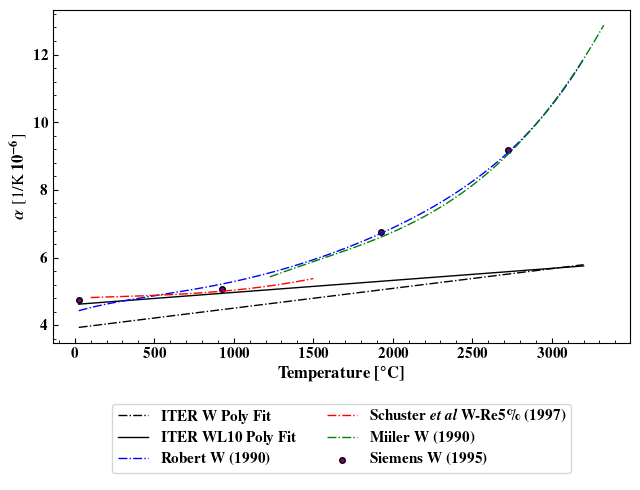

In [10]:
fig,(ax,legend_ax) = plt.subplots(nrows = 2,figsize = (6.5,5),height_ratios = [4,1])
setup_axis_default(ax)

ax.plot(xplot_iter,iterw_poly(xplot_iter),linewidth = 1.,color = 'k',
        label = r'\textbf{ITER W Poly Fit}',linestyle = '-.')

ax.plot(xplot_iter,iterwl10_poly(xplot_iter),linewidth = 1.0,color = 'k',
        label = r'\textbf{ITER WL10 Poly Fit}',linestyle = '-')

ax.plot(xplot_iter,white_minges_poly(xplot_iter + 273.15),linewidth = 1.,color = 'blue',
        label = r'\textbf{Robert W (1990)}',linestyle = '-.')

ax.plot(xplot_schuster,schuster_poly(xplot_schuster),linewidth = 1.,color = 'red',
        label = r'\textbf{Schuster \textit{et al} W-Re5\% (1997)}',linestyle = '-.')

ax.plot(xplot_miiller - 273.15,miiller_poly(xplot_miiller),linewidth = 1.,color = 'green',
        label = r'\textbf{Miiler W (1990)}',linestyle = '-.')

ax.scatter(x_siemen,cte_siemen,s = 16,edgecolor  ='k',facecolor = 'purple',label = r'\textbf{Siemens W (1995)}')

handles,labels = ax.get_legend_handles_labels()
legend_ax.legend(handles = handles,loc = 'center',ncol = 2,fontsize = 11)
legend_ax.axis('off')

ax.set_xlabel(r'\textbf{Temperature} \textbf{[}$^\circ$\textbf{C]}',fontsize = 12)
ax.set_ylabel(r'$\alpha$ [1/K $10^{-6}$]',fontsize = 12)

fig.tight_layout()
fig.savefig('../images/cte_de.svg')